In [ ]:
!pip uninstall keras -y
!pip install git+https://github.com/qubvel/segmentation_models
!git clone https://github.com/SlinkoIgor/ImageDataAugmentor.git

Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-licbh1jm
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-licbh1jm
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 7.0MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=1b4eea38be250bbc45728c67c3518159937056d1ca8bbc2ab5e0c3652741f086
  Stored in directory: /tmp/pip-ephem-wheel-cache-2t_vcfea/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 310, done.
remote: Total 310 (delta 0), reused 0 (delta 0), pack-reused 310
Receiving objects: 100% (310/310), 131.62 KiB | 21.94 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [ ]:
from google.colab import drive
drive.mount('/content/rdrive')

Mounted at /content/rdrive


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia = np.load('/content/rdrive/MyDrive/covid-segmentation/images_radiopedia.npy').astype(np.float32)
masks_radiopedia = np.load('/content/rdrive/MyDrive/covid-segmentation/masks_radiopedia.npy').astype(np.int8)
images_medseg = np.load('/content/rdrive/MyDrive/covid-segmentation/images_medseg.npy').astype(np.float32)
masks_medseg = np.load('/content/rdrive/MyDrive/covid-segmentation/masks_medseg.npy').astype(np.int8)

test_images_medseg = np.load('/content/rdrive/MyDrive/covid-segmentation/test_images_medseg.npy').astype(np.float32)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])

        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()
      

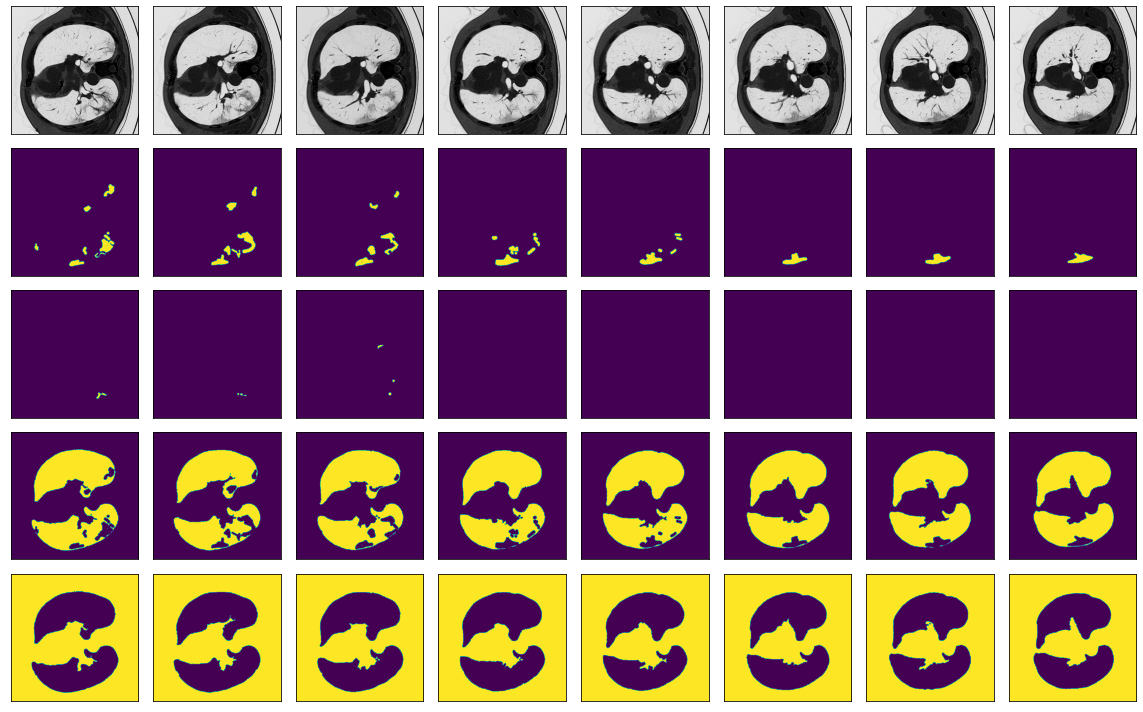

In [ ]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])


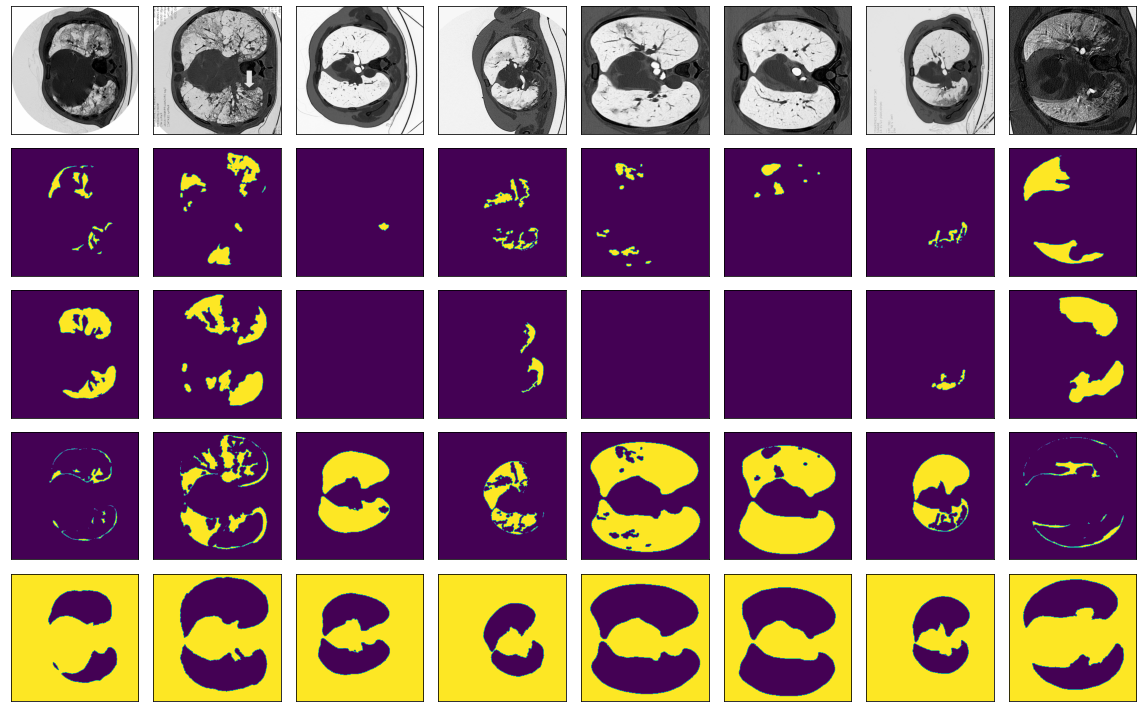

In [ ]:
visualize(images_medseg, masks_medseg)

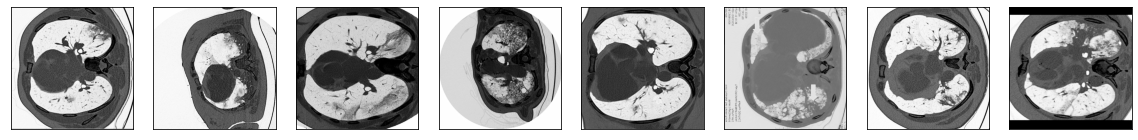

In [ ]:
visualize(test_images_medseg)

In [ ]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();

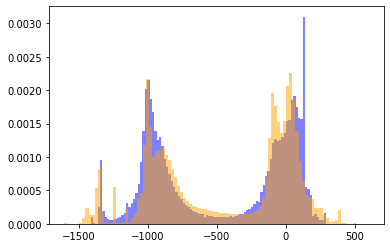

In [ ]:
plot_hists(images_radiopedia, images_medseg)

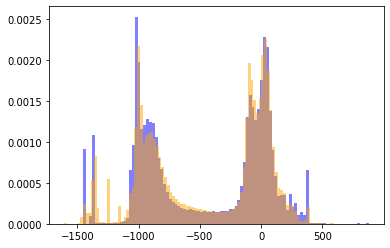

In [ ]:
plot_hists(test_images_medseg, images_medseg)

In [ ]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


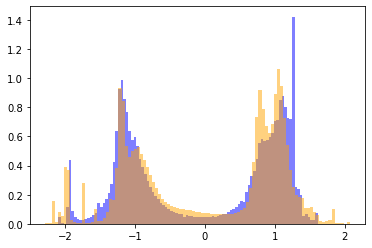

In [ ]:
plot_hists(images_radiopedia, images_medseg)

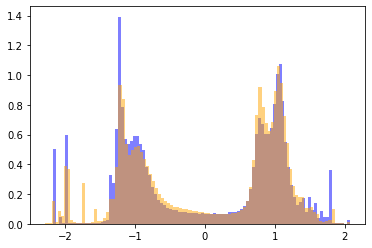

In [ ]:
plot_hists(test_images_medseg, images_medseg)

In [ ]:
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg[train_indexes], masks_radiopedia))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg[val_indexes]

batch_size = len(val_masks)

del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

In [ ]:
import tensorflow

import albumentations
import cv2

SOURCE_SIZE = 512
TARGET_SIZE = 256

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])


val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [ ]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
        
class Dataloder(tensorflow.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
        
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
assert train_dataloader[0][0].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 1)
assert train_dataloader[0][1].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 4)

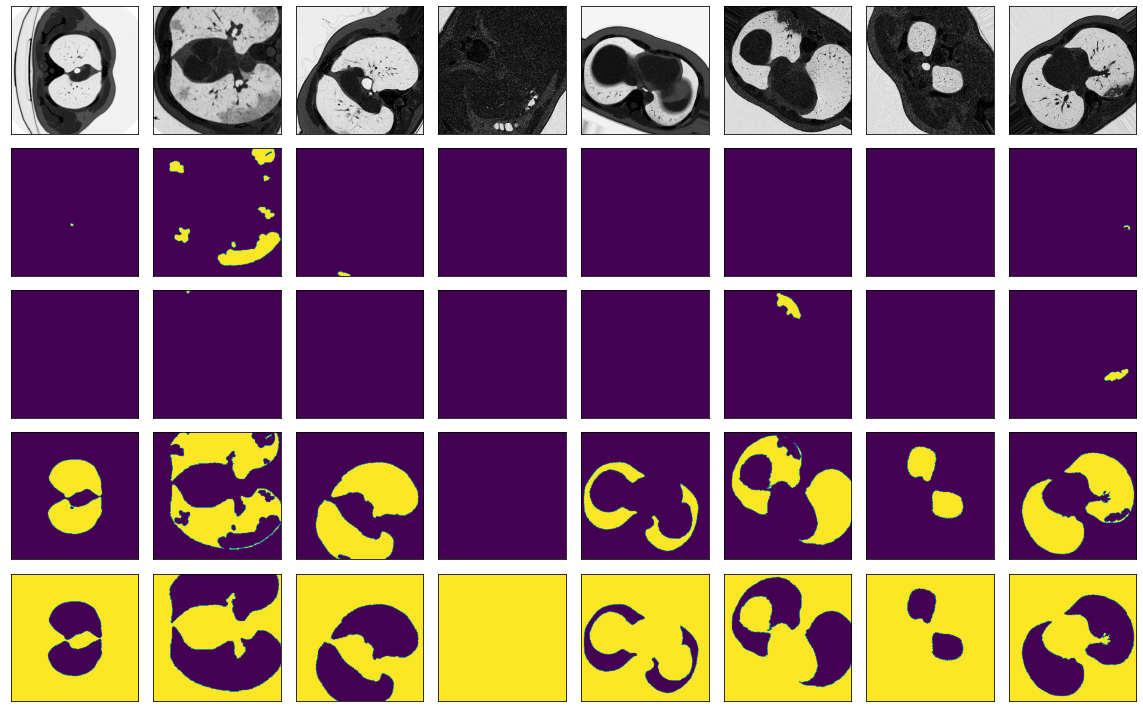

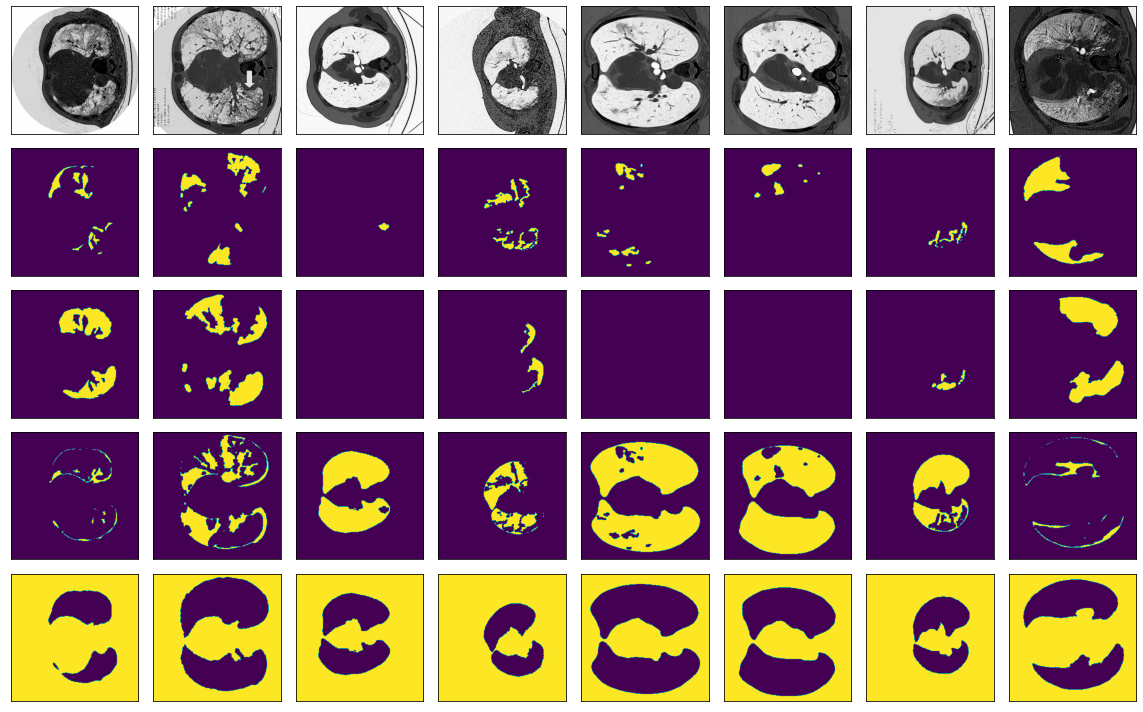

In [ ]:
visualize(*next(iter(train_dataloader)))
visualize(*next(iter(val_dataloader)))

In [ ]:
def fscore_glass(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 0:1], 
                               y_pred[..., 0:1])
    
def fscore_consolidation(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 1:2], 
                               y_pred[..., 1:2])

def fscore_lungs_other(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 2:3], 
                               y_pred[..., 2:3])

def fscore_glass_and_consolidation(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., :2], 
                               y_pred[..., :2])

In [ ]:
from segmentation_models import Unet
import segmentation_models as sm

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = Unet(backbone_name='efficientnetb0',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])
    
model.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss=sm.losses.categorical_crossentropy,
              metrics=[fscore_glass, fscore_consolidation, fscore_lungs_other, fscore_glass_and_consolidation])

checkpoint_callback = ModelCheckpoint('best_model',
                                      monitor='fscore_glass_and_consolidation',
                                      mode='max',
                                      save_best_only=True)

model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader) * 6,
    epochs=10,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[checkpoint_callback],
    workers=4)

Segmentation Models: using `tf.keras` framework.
16809984/16804768 [==============================] - 0s 0us/step
Epoch 1/10
222/222 [==============================] - 164s 531ms/step - loss: 0.0780 - fscore_glass: 0.2266 - fscore_consolidation: 0.0463 - fscore_lungs_other: 0.7640 - fscore_glass_and_consolidation: 0.1364 - val_loss: 0.0799 - val_fscore_glass: 0.1926 - val_fscore_consolidation: 0.1448 - val_fscore_lungs_other: 0.8518 - val_fscore_glass_and_consolidation: 0.1687
INFO:tensorflow:Assets written to: best_model/assets
Epoch 2/10
222/222 [==============================] - 117s 526ms/step - loss: 0.0116 - fscore_glass: 0.6358 - fscore_consolidation: 0.1903 - fscore_lungs_other: 0.9469 - fscore_glass_and_consolidation: 0.4131 - val_loss: 0.0588 - val_fscore_glass: 0.5083 - val_fscore_consolidation: 0.1377 - val_fscore_lungs_other: 0.8831 - val_fscore_glass_and_consolidation: 0.3230
INFO:tensorflow:Assets written to: best_model/assets
Epoch 3/10
222/222 [========================

In [ ]:
model = tensorflow.keras.models.load_model('best_model/',
                                           compile=False,
                                           custom_objects={
                                                'categorical_crossentropy': sm.losses.categorical_crossentropy,
                                                'fscore_consolidation': fscore_consolidation, 
                                                'fscore_glass': fscore_glass, 
                                                'fscore_lungs_other': fscore_lungs_other,
                                                'fscore_glass_and_consolidation': fscore_glass_and_consolidation})

model.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss=sm.losses.jaccard_loss)

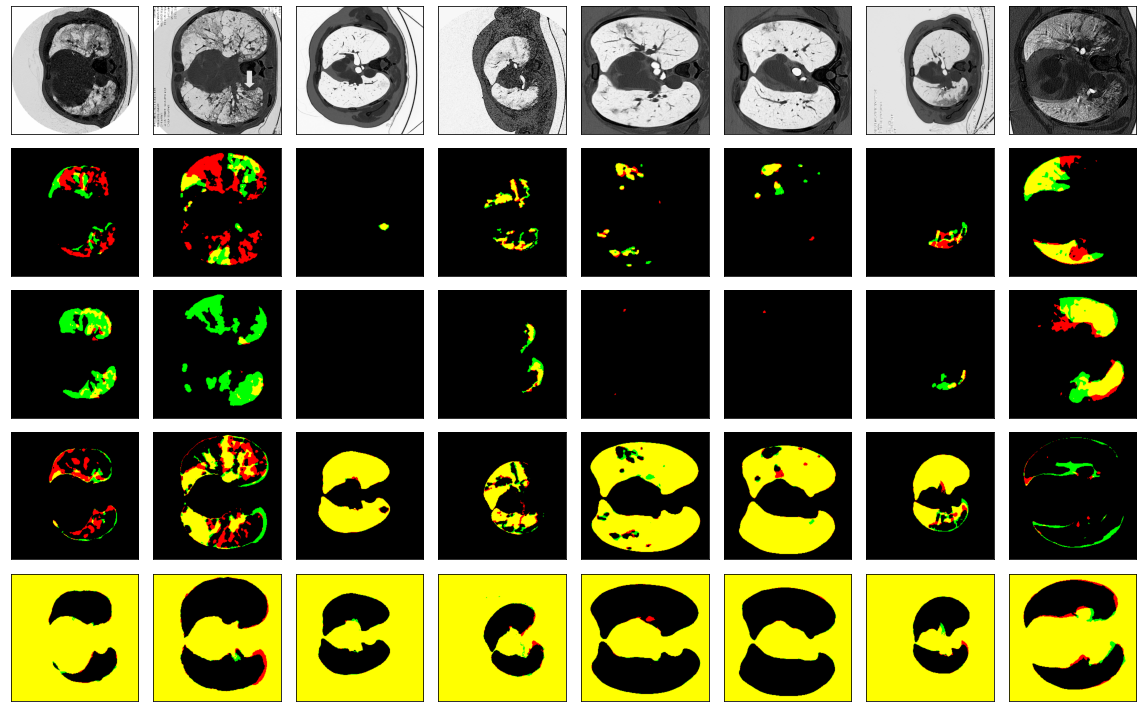

In [ ]:
input = val_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN.

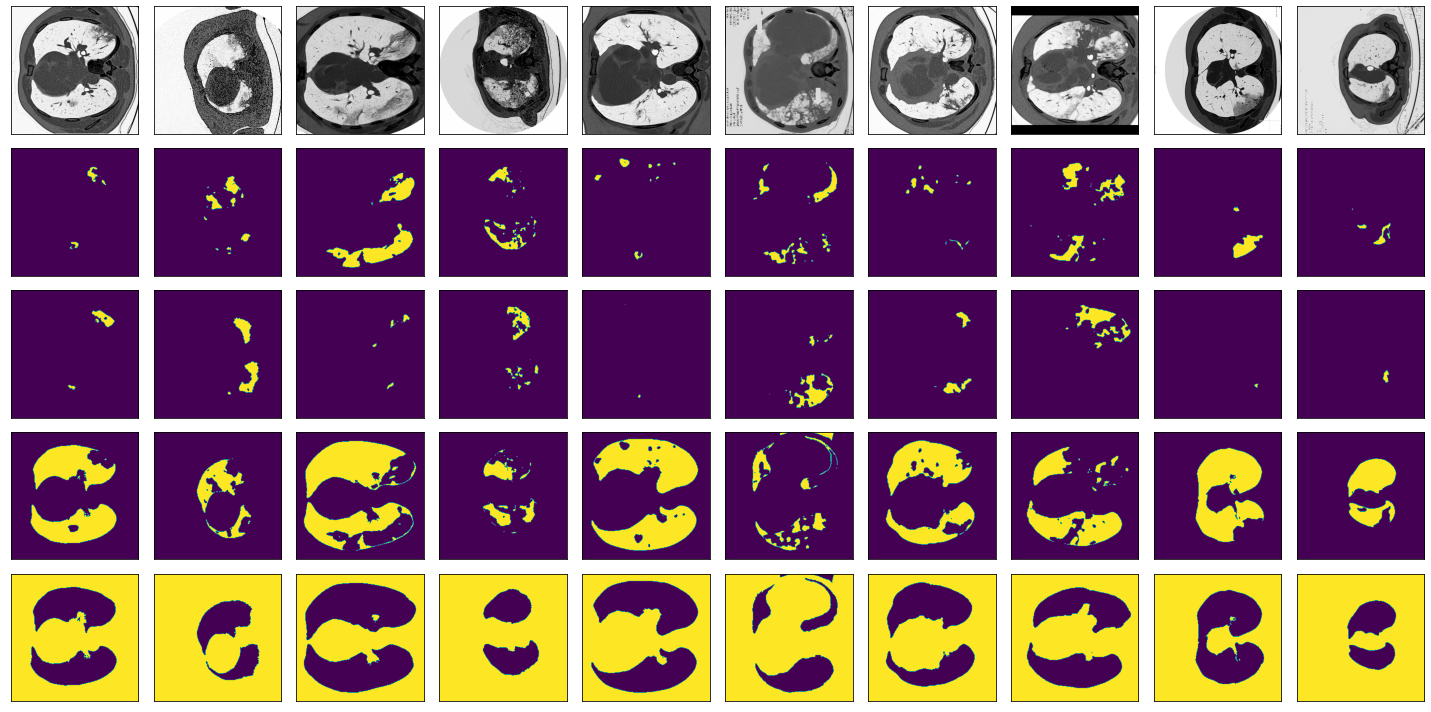

In [ ]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
test_preds = model.predict_on_batch(image_batch)
test_masks_prediction = test_preds > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

In [ ]:
import scipy
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [ ]:
import pandas as pd

pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('submission.csv')